In [1]:
from osgeo import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
from anytree import Node, RenderTree, NodeMixin
from anytree.exporter import DotExporter
from anytree.dotexport import RenderTreeGraph
from multiprocess import Process, Queue

In [2]:
#Возьмем тренировочные данные
#328930.0184,330487.6492,4200807.9496,4202455.4870 [EPSG:32614]
#335585.1422,336057.3203,4210112.1965,4210481.0856 [EPSG:32614]
#328167.3988,328411.1949,4199804.3245,4199922.9279 [EPSG:32614]
#344778.9990,345583.0668,4193951.2446,4194700.3334 [EPSG:32614]
#320457.2751,321708.0471,4202522.4693,4203354.0266 [EPSG:32614]

#329449.6019,329970.1722,4202967.8065,4203356.5869 [EPSG:32614]
#315166.2769,324971.4494,4198424.1092,4205136.6108 [EPSG:32614]
#346388.6887,348881.2188,4193749.9146,4195567.9954 [EPSG:32614]
#346371.9777,348285.7235,4193896.9826,4195565.2967 [EPSG:32614]

## Theory about speed

#### Important links
- https://habr.com/ru/company/vdsina/blog/552378/
- https://numpy.org/doc/stable/reference/ufuncs.html#math-operations

## Константы для построения дерева

In [3]:
#global alpha #alpha for sig
#alpha = 0.7 #будем подбирать альфу

In [101]:
global c0  #min node size
#c0 = 50 #примерное значение для 500х500
c0 = 7

In [5]:
global ndvi 
ndvi = 0.15 #ndvi const

In [6]:
global fichi
fichi = 8

## Откроем тренировочные данные

### NDVI

In [7]:
#/Users/the_icecream/Desktop/проверка/NDVI_alfa.tif
NDVI = gdal.Open("/Users/the_icecream/Desktop/проверка/NDVI_alfa.tif", gdal.GA_ReadOnly)
for x in range(1, NDVI.RasterCount + 1):
    band = NDVI.GetRasterBand(x)
    ndvi_arr = band.ReadAsArray()

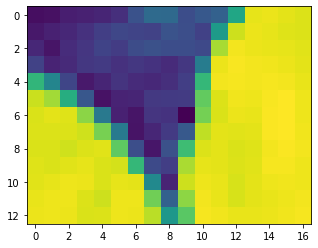

In [8]:
plt.imshow(ndvi_arr)

In [9]:
ndvi_arr

array([[0.22891487, 0.23140715, 0.24439648, 0.2473818 , 0.25055414,
        0.26173875, 0.3009208 , 0.33112323, 0.33089334, 0.295707  ,
        0.3086255 , 0.31950265, 0.4144899 , 0.53800946, 0.5401996 ,
        0.53597033, 0.53259265],
       [0.23760177, 0.24745418, 0.25343797, 0.2639786 , 0.2781576 ,
        0.28674898, 0.28494743, 0.28157467, 0.30110425, 0.29601917,
        0.2810196 , 0.39829376, 0.52415127, 0.5406819 , 0.53794414,
        0.5342671 , 0.53236026],
       [0.25287914, 0.23523523, 0.2590909 , 0.2687444 , 0.28334552,
        0.27579027, 0.29400346, 0.2986717 , 0.29516187, 0.29460144,
        0.29019564, 0.50711167, 0.54489166, 0.5406937 , 0.5396935 ,
        0.5376211 , 0.5355269 ],
       [0.2822938 , 0.25014403, 0.2564536 , 0.27053365, 0.27354088,
        0.2639906 , 0.2702754 , 0.2651938 , 0.25684774, 0.26982906,
        0.3563573 , 0.54060024, 0.5473291 , 0.54394853, 0.54261804,
        0.5405413 , 0.53641355],
       [0.43569455, 0.36805367, 0.28586864, 0.239034

### Исходные данные (truth ground)

In [10]:
#/Users/the_icecream/Desktop/проверка/CR_alfa.tif
dataset = gdal.Open("/Users/the_icecream/Desktop/проверка/CR_alfa.tif", gdal.GA_ReadOnly)
for x in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(x)
    truth = band.ReadAsArray()

(13, 17)

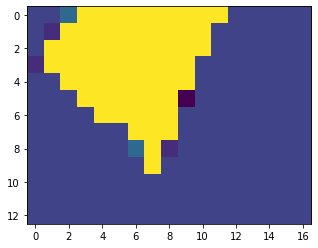

In [11]:
plt.imshow(truth)
truth.shape

In [12]:
truth

array([[ 36,  36,  61, 176, 176, 176, 176, 176, 176, 176, 176, 176,  36,
         36,  36,  36,  36],
       [ 36,  24, 176, 176, 176, 176, 176, 176, 176, 176, 176,  36,  36,
         36,  36,  36,  36],
       [ 36, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176,  36,  36,
         36,  36,  36,  36],
       [ 24, 176, 176, 176, 176, 176, 176, 176, 176, 176,  36,  36,  36,
         36,  36,  36,  36],
       [ 36,  36, 176, 176, 176, 176, 176, 176, 176, 176,  36,  36,  36,
         36,  36,  36,  36],
       [ 36,  36,  36, 176, 176, 176, 176, 176, 176,   1,  36,  36,  36,
         36,  36,  36,  36],
       [ 36,  36,  36,  36, 176, 176, 176, 176, 176,  36,  36,  36,  36,
         36,  36,  36,  36],
       [ 36,  36,  36,  36,  36,  36, 176, 176, 176,  36,  36,  36,  36,
         36,  36,  36,  36],
       [ 36,  36,  36,  36,  36,  36,  61, 176,  24,  36,  36,  36,  36,
         36,  36,  36,  36],
       [ 36,  36,  36,  36,  36,  36,  36, 176,  36,  36,  36,  36,  36,
         

In [13]:
array = np.array(truth, dtype = object)

In [14]:
array.shape

(13, 17)

### Тренировочные данные Band01

In [15]:
#/Users/the_icecream/Desktop/проверка/Band01_alfa.tif
data01 = gdal.Open("/Users/the_icecream/Desktop/проверка/Band01_alfa.tif", gdal.GA_ReadOnly)
for x in range(1, data01.RasterCount + 1):
    band = data01.GetRasterBand(x)
    array01 = band.ReadAsArray()

(13, 17)

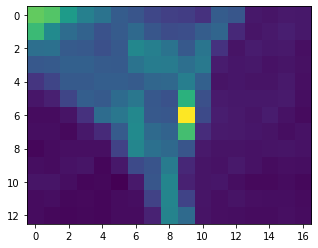

In [16]:
plt.imshow(array01)
array01.shape

### Тренировочные данные Band02

In [17]:
#/Users/the_icecream/Desktop/проверка/Band02_alfa.tif
data02 = gdal.Open("/Users/the_icecream/Desktop/проверка/Band02_alfa.tif", gdal.GA_ReadOnly)
for x in range(1, data02.RasterCount + 1):
    band = data02.GetRasterBand(x)
    array02 = band.ReadAsArray()

(13, 17)

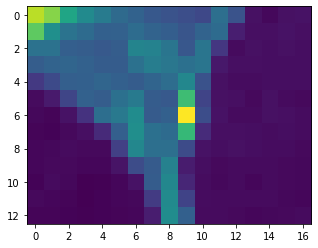

In [18]:
plt.imshow(array02)
array02.shape

### Тренировочные данные Band03

In [19]:
#/Users/the_icecream/Desktop/проверка/Band03_alfa.tif
data03 = gdal.Open("/Users/the_icecream/Desktop/проверка/Band03_alfa.tif", gdal.GA_ReadOnly)
for x in range(1, data03.RasterCount + 1):
    band = data03.GetRasterBand(x)
    array03 = band.ReadAsArray()

(13, 17)

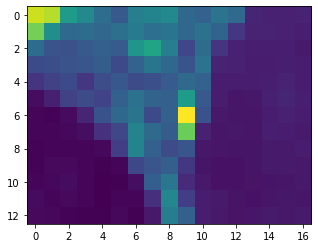

In [20]:
plt.imshow(array03)
array03.shape

### Тренировочные данные Band04

In [21]:
#/Users/the_icecream/Desktop/проверка/Band04_alfa.tif
data04 = gdal.Open("/Users/the_icecream/Desktop/проверка/Band04_alfa.tif", gdal.GA_ReadOnly)
for x in range(1, data04.RasterCount + 1):
    band = data04.GetRasterBand(x)
    array04 = band.ReadAsArray()

(13, 17)

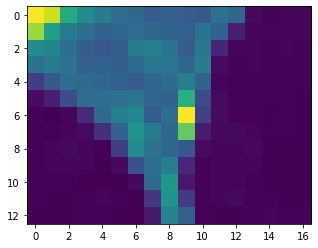

In [22]:
plt.imshow(array04)
array04.shape

### Тренировочные данные Band05

In [23]:
#/Users/the_icecream/Desktop/проверка/Band05_alfa.tif
data05 = gdal.Open("/Users/the_icecream/Desktop/проверка/Band05_alfa.tif", gdal.GA_ReadOnly)
for x in range(1, data05.RasterCount + 1):
    band = data05.GetRasterBand(x)
    array05 = band.ReadAsArray()

(13, 17)

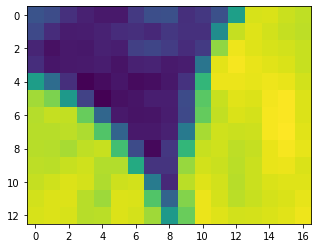

In [25]:
plt.imshow(array05)
array05.shape

### Тренировочные данные Band06

In [26]:
#/Users/the_icecream/Desktop/проверка/Band06_alfa.tif
data06 = gdal.Open("/Users/the_icecream/Desktop/проверка/Band06_alfa.tif", gdal.GA_ReadOnly)
for x in range(1, data06.RasterCount + 1):
    band = data06.GetRasterBand(x)
    array06 = band.ReadAsArray()

(13, 17)

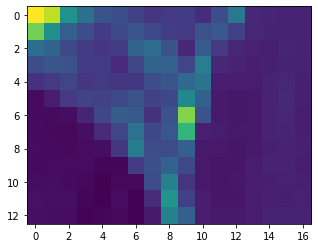

In [27]:
plt.imshow(array06)
array06.shape

### Тренировочные данные Band07

In [28]:
#/Users/the_icecream/Desktop/проверка/Band07_alfa.tif
data07 = gdal.Open("/Users/the_icecream/Desktop/проверка/Band07_alfa.tif", gdal.GA_ReadOnly)
for x in range(1, data07.RasterCount + 1):
    band = data07.GetRasterBand(x)
    array07 = band.ReadAsArray()

(13, 17)

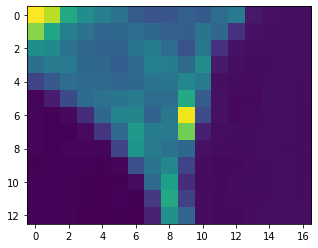

In [29]:
plt.imshow(array07)
array07.shape

In [30]:
np.unique(array07).shape

(196,)

### Тренировочные данные Band10

In [31]:
#/Users/the_icecream/Desktop/проверка/Band10_alfa.tif
data10 = gdal.Open("/Users/the_icecream/Desktop/проверка/Band10_alfa.tif", gdal.GA_ReadOnly)
for x in range(1, data10.RasterCount + 1):
    band = data10.GetRasterBand(x)
    array10 = band.ReadAsArray()

(13, 17)

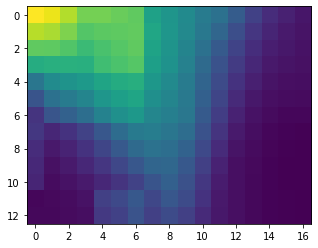

In [32]:
plt.imshow(array10)
array10.shape

In [33]:
bands = {0:array01, 1:array02, 2:array03, 3:array04, 4:array05, 5:array06, 6:array07, 7:array10}

## Making matrix of features

In [34]:
bands

{0: array([[9355, 9319, 9083, 8938, 8868, 8756, 8721, 8658, 8626, 8615, 8565,
         8758, 8727, 8468, 8456, 8474, 8468],
        [9252, 8995, 8837, 8784, 8707, 8753, 8818, 8725, 8683, 8693, 8763,
         8799, 8530, 8456, 8471, 8492, 8467],
        [8851, 8854, 8751, 8743, 8695, 8743, 8973, 8933, 8870, 8741, 8882,
         8573, 8453, 8481, 8465, 8474, 8439],
        [8736, 8744, 8775, 8776, 8750, 8746, 8868, 8919, 8917, 8852, 8901,
         8483, 8463, 8466, 8445, 8456, 8442],
        [8584, 8650, 8744, 8746, 8767, 8765, 8753, 8805, 8817, 8929, 8774,
         8453, 8460, 8454, 8452, 8474, 8435],
        [8460, 8498, 8653, 8768, 8747, 8832, 8892, 8734, 8704, 9201, 8698,
         8475, 8468, 8468, 8466, 8475, 8432],
        [8429, 8427, 8450, 8567, 8837, 8892, 8980, 8741, 8730, 9659, 8671,
         8488, 8470, 8456, 8482, 8447, 8421],
        [8431, 8431, 8416, 8466, 8539, 8753, 8996, 8827, 8792, 9279, 8548,
         8478, 8472, 8464, 8454, 8431, 8447],
        [8408, 8427, 8439, 84

In [35]:
features = np.zeros((array.shape[0], array.shape[1]), dtype = tuple)
for i in range(array.shape[0]):
    for j in range(array.shape[1]):
        features[i][j] = (bands[0][i][j], bands[1][i][j], bands[2][i][j], bands[3][i][j], bands[4][i][j], bands[5][i][j], bands[6][i][j], bands[7][i][j])

In [36]:
features

array([[(9355, 9811, 11114, 11835, 18862, 20203, 16054, 47734),
        (9319, 9688, 11046, 11585, 18561, 19602, 15411, 47644),
        (9083, 9324, 10388, 10501, 17294, 17177, 13649, 47377),
        (8938, 9149, 10224, 10061, 16675, 16307, 12925, 47074),
        (8868, 9053, 10008, 9805, 16361, 15645, 12553, 47076),
        (8756, 8941, 9850, 9583, 16378, 15519, 12265, 47020),
        (8721, 8891, 10140, 9490, 17660, 15207, 11731, 46973),
        (8658, 8830, 10187, 9382, 18671, 14977, 11499, 46396),
        (8626, 8804, 10226, 9415, 18727, 15070, 11562, 46239),
        (8615, 8774, 9969, 9384, 17264, 15098, 11811, 46100),
        (8565, 8738, 9919, 9318, 17637, 14834, 11666, 45901),
        (8758, 8976, 10061, 9660, 18731, 15498, 12138, 45770),
        (8727, 8804, 9974, 9504, 22960, 16498, 12448, 45515),
        (8468, 8471, 9507, 8411, 28001, 14750, 10351, 45207),
        (8456, 8434, 9484, 8364, 28017, 14676, 10195, 44998),
        (8474, 8466, 9482, 8382, 27745, 14650, 10179, 448

### Составим класс смежностей

In [37]:
label = np.zeros(((array.shape[0], array.shape[1])), dtype='uint16')
for i in range(array.shape[0]):
    for j in range(array.shape[1]):
        if (array[i][j] == 36 and ndvi_arr[i][j] >= ndvi):
            label[i][j] = 36 #alfalfa

In [38]:
label

array([[36, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 36, 36, 36, 36,
        36],
       [36,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 36, 36, 36, 36, 36,
        36],
       [36,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 36, 36, 36, 36, 36,
        36],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 36, 36, 36, 36, 36, 36,
        36],
       [36, 36,  0,  0,  0,  0,  0,  0,  0,  0, 36, 36, 36, 36, 36, 36,
        36],
       [36, 36, 36,  0,  0,  0,  0,  0,  0,  0, 36, 36, 36, 36, 36, 36,
        36],
       [36, 36, 36, 36,  0,  0,  0,  0,  0, 36, 36, 36, 36, 36, 36, 36,
        36],
       [36, 36, 36, 36, 36, 36,  0,  0,  0, 36, 36, 36, 36, 36, 36, 36,
        36],
       [36, 36, 36, 36, 36, 36,  0,  0,  0, 36, 36, 36, 36, 36, 36, 36,
        36],
       [36, 36, 36, 36, 36, 36, 36,  0, 36, 36, 36, 36, 36, 36, 36, 36,
        36],
       [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36],
       [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 3

## Составим матрицу смежности

In [39]:
#построение матрицы смежности
#номер пикселя == (i-1)*array.shape[1]+j

def w_matrix(array):
    size = (array.shape[0])*(array.shape[1])
    w_matrix = np.zeros((size, size), dtype=object)
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            num = (i)*array.shape[1]+j
            # cоседи по горизонтали
            if (num - 1 >= 0 and j != 0):
                w_matrix[num][num-1] = 1
            if (num + 1 < size and j != (array.shape[1]-1)):
                w_matrix[num][num+1] = 1
            
            # соседи по вертикали 
            if (num - array.shape[1] >= 0):
                w_matrix[num][num - array.shape[1]] = 1
            if (num + array.shape[1] < size):
                w_matrix[num][num + array.shape[1]] = 1
    return w_matrix  

## Вычисление IG, NSAR, SIG

### Разделение исходных данных

###  Вычисление $\overline{NSAR}$

In [40]:
#посмотрим все features в тренировочных данных
np.unique(array05).size

218

In [41]:
np.unique(array07).size

196

#### $Gamma Index$

In [42]:
def Gamma_Index(pixel, arr_pixels, label): #на вход получаем пиксель, матрицу пикселей с разделением
        i = pixel[0]
        j = pixel[1]
        G_i = 0
        if (i - 1 >= 0 ):
            if (arr_pixels[i-1][j] != None and label[i-1][j] == label[i][j]):
                G_i += 1
        if (i+1 < arr_pixels.shape[0]):
            if (arr_pixels[i+1][j] != None and label[i+1][j] == label[i][j]):
                G_i += 1
        
        if (j-1 >= 0):
            if (arr_pixels[i][j-1] != None and label[i][j-1] == label[i][j]):
                G_i += 1
        if (j+1 < arr_pixels.shape[1]):
            if (arr_pixels[i][j+1] != None and label[i][j+1] == label[i][j]):
                G_i += 1
            
        return G_i

#### $NSAR$

In [43]:
def NSAR(pixel, splited, label) -> 'float32':
    G_before = Gamma_Index(pixel, array, label)
    i = pixel[0]
    j = pixel[1]
    if (splited[0][i][j] == None):
        G_after = Gamma_Index(pixel, splited[1], label)
    else:
        G_after = Gamma_Index(pixel, splited[0], label)
    if (G_before == 0):
        if (G_after == 0):
            return 1.0
        else:
            return 0.0
    else:
        return G_after/G_before

#### $\overline{NSAR}$

In [44]:
def NSAR_av(splited, label):
    amN = 0
    count = 0
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            num = [i,j]
            amN += NSAR(num, splited, label)
            count += 1
    return amN/count

In [45]:
array07

array([[16054, 15411, 13649, 12925, 12553, 12265, 11731, 11499, 11562,
        11811, 11666, 12138, 12448, 10351, 10195, 10179, 10172],
       [14945, 13555, 12548, 12257, 11922, 11987, 12136, 12002, 11802,
        11784, 12294, 11947, 10806, 10224, 10189, 10169, 10160],
       [12979, 12860, 12237, 11971, 11852, 11849, 12307, 12493, 12127,
        11493, 12325, 10814, 10232, 10175, 10155, 10176, 10153],
       [12189, 12459, 12438, 11965, 11996, 11766, 12026, 12569, 12493,
        12055, 12946, 10358, 10180, 10133, 10127, 10163, 10143],
       [11182, 11639, 12107, 12052, 12049, 11920, 12004, 12295, 12318,
        12791, 12444, 10189, 10119, 10114, 10154, 10166, 10129],
       [10036, 10400, 11312, 12076, 12223, 12297, 12471, 12122, 12106,
        13665, 11737, 10193, 10086, 10091, 10147, 10148, 10124],
       [10012,  9994, 10077, 10731, 11983, 12696, 12714, 11848, 12412,
        15922, 11368, 10199, 10093, 10109, 10148, 10153, 10112],
       [10011,  9981,  9989, 10112, 10859, 12032

In [46]:
sp = subgraph(array, bands, 7, 9864)

NameError: name 'subgraph' is not defined

In [ ]:
%time NSAR_av(sp, label)

### Вычисление IG

In [47]:
def find_un(array, label):
    a = np.where(array != None, label, -10000)
    unique, counts = np.unique(a, return_counts=True)
    un = dict(zip(unique, counts))
    if (-10000 in un.keys()):
        del un[-10000]
    return un

In [48]:
def find_size(array):
    return np.count_nonzero(array)

#### $Entropy$

In [49]:
def Entropy(array, size, label):
    un = np.array(list(find_un(array, label).values()), dtype='uint32')
    p = np.true_divide(un, size)
    entropy = np.sum(np.multiply(p, np.log2(p)))
    return -1*entropy

#### $IG$ 

In [50]:
def IG(splited, array, label):
    size = array.shape[0]*array.shape[1]
    E = Entropy(array, size, label)
    
    #entropy <= F
    spl_0 = splited[0]
    size_0 = find_size(spl_0)
    E_0 = Entropy(spl_0, size_0, label)
    
    
    #entropy > F
    spl_1 = splited[1]
    size_1 = size - size_0
    E_1 = Entropy(spl_1, size_1,  label)
    
    
    E_av = ((size_0)/size)*E_0 + ((size_1)/size)*E_1
    
    ig = E - E_av
    return ig

###  Вычисление $SIG$

In [90]:
def SIG(array, bands, band, F, label, alpha, subs):
    ig = IG(subs, array,label)
    Nsar = NSAR_av(subs, label)
    sig = (1-alpha)*ig + alpha*Nsar
    return sig

###  Вычисление размера графа смежных пикселей

In [52]:
#функция find_size

### Проверка принадлежности подграфа классу

In [53]:
def check_class(array, label):
    size = find_size(array)
    uniq = find_un(array,label)
    for x in uniq.keys():
        if (uniq[x] == size):
            return (True, x)
    return (False, None)

### Разделение на подграфы

In [54]:
def subgraph(array, bands, band, F):
    arr_above = np.where(bands[band] > F, array, None)
    arr_below = np.where(bands[band]<= F, array, None)
    return [arr_below, arr_above]

In [55]:
def find_band(band):
    return bands[band]

## Алгоритм $SDT-Train$

### Making BinMask

We will have 3 types of mask : $\begin{equation*}
pixel = 
 \begin{cases}
   36 &\text{if it is in alfalfa class}\\
   0 &\text{if it is in other class} \\
   1 &\text{if it was distributed by size}
 \end{cases}
\end{equation*}$

In [56]:
#global binmask
#binmask = np.zeros((array.shape[0], array.shape[1]), dtype='uint8')

### $INPUT$

#### $Neighborhood$ $graph$

In [58]:
w_matrix = w_matrix(array)

In [59]:
w_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]], dtype=object)

#### $Feature$ $set$

In [60]:
features

array([[(9355, 9811, 11114, 11835, 18862, 20203, 16054, 47734),
        (9319, 9688, 11046, 11585, 18561, 19602, 15411, 47644),
        (9083, 9324, 10388, 10501, 17294, 17177, 13649, 47377),
        (8938, 9149, 10224, 10061, 16675, 16307, 12925, 47074),
        (8868, 9053, 10008, 9805, 16361, 15645, 12553, 47076),
        (8756, 8941, 9850, 9583, 16378, 15519, 12265, 47020),
        (8721, 8891, 10140, 9490, 17660, 15207, 11731, 46973),
        (8658, 8830, 10187, 9382, 18671, 14977, 11499, 46396),
        (8626, 8804, 10226, 9415, 18727, 15070, 11562, 46239),
        (8615, 8774, 9969, 9384, 17264, 15098, 11811, 46100),
        (8565, 8738, 9919, 9318, 17637, 14834, 11666, 45901),
        (8758, 8976, 10061, 9660, 18731, 15498, 12138, 45770),
        (8727, 8804, 9974, 9504, 22960, 16498, 12448, 45515),
        (8468, 8471, 9507, 8411, 28001, 14750, 10351, 45207),
        (8456, 8434, 9484, 8364, 28017, 14676, 10195, 44998),
        (8474, 8466, 9482, 8382, 27745, 14650, 10179, 448

#### $Class$ $label$ $set$

In [61]:
print(label)

[[36 36  0  0  0  0  0  0  0  0  0  0 36 36 36 36 36]
 [36  0  0  0  0  0  0  0  0  0  0 36 36 36 36 36 36]
 [36  0  0  0  0  0  0  0  0  0  0 36 36 36 36 36 36]
 [ 0  0  0  0  0  0  0  0  0  0 36 36 36 36 36 36 36]
 [36 36  0  0  0  0  0  0  0  0 36 36 36 36 36 36 36]
 [36 36 36  0  0  0  0  0  0  0 36 36 36 36 36 36 36]
 [36 36 36 36  0  0  0  0  0 36 36 36 36 36 36 36 36]
 [36 36 36 36 36 36  0  0  0 36 36 36 36 36 36 36 36]
 [36 36 36 36 36 36  0  0  0 36 36 36 36 36 36 36 36]
 [36 36 36 36 36 36 36  0 36 36 36 36 36 36 36 36 36]
 [36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
 [36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
 [36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]]


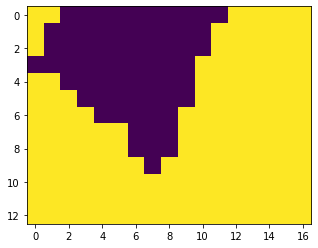

In [62]:
plt.imshow(label)

#### $NODE$

In [63]:
class Node(NodeMixin):
     def __init__(self, name, displ_name = None, internal = None, parent = None, children = None):
            self.parent = parent
            self.name = name
            if displ_name:
                self.displ_name = displ_name
            if internal:
                self.internal = internal
            if children:
                self.children = children

#### making unique ID

In [64]:
#global names
#names = [0]

In [65]:
def id_n(names):
    names.append(names[len(names)-1]+1)
    return names[len(names)-1]

#### $Algorithm$

In [66]:
def pr_names(band):
    if (band <= 6):
        return "".join(["band0",str(band+1)])
    else:
        return "band10"

In [107]:
def thr_sig(array, bands, x,label, alpha, q):
    m_sig = -100
    r_subs = []
    arr_f = np.unique(bands[x])
    for F in arr_f:
        subs = subgraph(array, bands, x, F)
        if (find_size(subs[0]) != 0 and find_size(subs[1]) != 0):
            sig = SIG(array, bands, x, F, label, alpha, subs)
            if (sig >= m_sig):
                m_sig = sig
                r_subs = subs
                new_node = [x, F]
    q.put((m_sig, r_subs, new_node))

In [68]:
import time
start_time = time.time()
processes = []
q = Queue()
rets = []
for x in  bands:
    p = Process(target=thr_sig, args=[array, bands, x,label, 0.4, q])
    p.start()
    processes.append(p)
    
for p in processes:
    ret = q.get() 
    rets.append(ret)
        
for p in processes:
    p.join()
    p.close()

del q
print("--- %s secs ---" % (time.time() - start_time))

--- 0.7895238399505615 secs ---


In [69]:
len(rets)

8

In [103]:
def SDT_train(array, features, label, alpha, names, binmask):
    print("ВХОД В АЛГОРИТМ:", find_size(array))
    ch = check_class(array, label)
    if (ch[0]):
        cl = ch[1]
        name = "".join(["class = ", str(cl)])
        leaf = Node(id_n(names), name)
        creating_mask(array, cl, binmask)
        print("Кол-во элементов != None:", find_size(array), sep="\n")
        return leaf
    elif (find_size(array) <= c0):
        name = "".join(["size <= ",str(c0)])
        leaf = Node(id_n(names), name) #создали лист с классом
        creating_mask(array, None, binmask)
        print("Кол-во элементов != None:", find_size(array), sep="\n")
        return leaf
    
    processes = []
    q = Queue()
    rets = []
    for x in  bands:
        p = Process(target=thr_sig, args=[array, bands, x,label, alpha, q])
        p.start()
        processes.append(p)
        
    for p in processes:
        ret = q.get() 
        rets.append(ret)
    
    for p in processes:
        p.join()
        p.close()
        
    del q
    del processes
    
    m_sig = -100
    tree_split = ()
    r_subs = []
    for item in rets:
        if (item[0] > m_sig):
            m_sig = item[0]
            r_subs = item[1]
            new_node = item[2]
    del rets
                    
    print("Разделение случилось: ",m_sig, find_size(r_subs[0]), find_size(r_subs[1]))
    name = pr_names(new_node[0]) + " " + "F <= " + str(new_node[1])
    int_node = Node(id_n(names), name)
    int_node.children = [SDT_train(r_subs[0], features, label,  alpha, names, binmask), SDT_train(r_subs[1], features, label,  alpha, names, binmask)]
    return int_node

### Alpha

In [104]:
def percent_error(binmask, label):
    right = np.sum(label == binmask)
    ans = right/(array.shape[0]*array.shape[1])
    return ans  

In [109]:
def finding_alpha():
    alpha = 0.0
    x1 = []
    y1 = []
    m_er = -1
    true_mask1 = []
    while alpha <= 1.0:
        print("alpha =",alpha)
        names = [0]
        binmask = np.zeros((array.shape[0], array.shape[1]), dtype='uint16')
        root = SDT_train(array, bands, label, alpha, names, binmask)
        DotExporter(root,
            nodeattrfunc=lambda node: 'label="{}"'.format(node.displ_name)).to_picture("".join(["graph_", str(alpha), ".png"]))
        x1.append(alpha)
        er = percent_error(binmask, label)
        print("\nКорректность выполнения алгоритма ==", er, "при альфа =", alpha,"\n")
        true_mask1.append(binmask)
        y1.append(er)
        alpha += 0.1
        alpha = round(alpha, 1)
    return (x1, y1,  true_mask1)

In [110]:
import time
start_time = time.time()
a = finding_alpha()
print("--- %s minutes ---" % str((time.time() - start_time)/60.0))

alpha = 0.0
ВХОД В АЛГОРИТМ: 221
Разделение случилось:  0.711138180724804 72 149
ВХОД В АЛГОРИТМ: 72
Разделение случилось:  0.5111673555247268 71 1
ВХОД В АЛГОРИТМ: 71
Разделение случилось:  0.5115078068637199 70 1
ВХОД В АЛГОРИТМ: 70
Разделение случилось:  0.512090278861658 69 1
ВХОД В АЛГОРИТМ: 69
Разделение случилось:  0.4917842150202925 68 1
ВХОД В АЛГОРИТМ: 68
Разделение случилось:  0.49062761941358435 67 1
ВХОД В АЛГОРИТМ: 67
Разделение случилось:  0.4893754315691787 66 1
ВХОД В АЛГОРИТМ: 66
Разделение случилось:  0.5090831282894083 65 1
ВХОД В АЛГОРИТМ: 65
Разделение случилось:  0.48647322024906303 64 1
ВХОД В АЛГОРИТМ: 64
Разделение случилось:  0.4849237747499076 63 1
ВХОД В АЛГОРИТМ: 63
Разделение случилось:  0.4832726931564011 62 1
ВХОД В АЛГОРИТМ: 62
Разделение случилось:  0.4815183582438138 61 1
ВХОД В АЛГОРИТМ: 61
Разделение случилось:  0.47965910096516806 60 1
ВХОД В АЛГОРИТМ: 60
Разделение случилось:  0.5016215549694689 59 1
ВХОД В АЛГОРИТМ: 59
Разделение случилось:  0.4

Разделение случилось:  0.4481579487721892 148 1
ВХОД В АЛГОРИТМ: 148
Разделение случилось:  0.45479671811129496 146 2
ВХОД В АЛГОРИТМ: 146
Кол-во элементов != None:
146
ВХОД В АЛГОРИТМ: 2
Кол-во элементов != None:
2
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1

Корректность выполнения алгоритма == 0.9819004524886877 при альфа = 0.3 

alpha = 0.4
ВХОД В АЛГОРИТМ: 221
Разделение случилось:  0.8122032704258326 72 149
ВХОД В АЛГОРИТМ: 72
Разделение случилось:  0.43022982507954194 71 1
ВХОД В АЛГОРИТМ: 71
Разделение случилось:  0.4302832663203435 70 1
ВХОД В АЛГОРИТМ: 70
Разделение случилось:  0.4279178173924096 69 1
ВХОД В АЛГОРИТМ: 69
Разделение случилось:  0.41241592871051636 68 1
ВХОД В АЛГОРИТМ: 68
Разделение случилось:  0.4088562096572004 67 1
ВХОД В АЛГОРИТМ: 67
Разделение случилось:  0.40523913526126587 66 1
ВХОД В АЛГОРИТМ: 66
Разделение случилось:  0.40156384743846996 65 1
ВХОД В АЛГОРИТМ: 65
Разделение случилось:  0.41341702050814233 64 1
ВХОД В АЛГОРИТМ: 64
Разделение случилос

Разделение случилось:  0.5676773696021042 146 2
ВХОД В АЛГОРИТМ: 146
Кол-во элементов != None:
146
ВХОД В АЛГОРИТМ: 2
Кол-во элементов != None:
2

Корректность выполнения алгоритма == 0.9819004524886877 при альфа = 0.7 

alpha = 0.8
ВХОД В АЛГОРИТМ: 221
Разделение случилось:  0.9191768350312233 73 148
ВХОД В АЛГОРИТМ: 73
Разделение случилось:  0.3582999174309407 72 1
ВХОД В АЛГОРИТМ: 72
Разделение случилось:  0.3514563396142307 70 2
ВХОД В АЛГОРИТМ: 70
Разделение случилось:  0.34374535592316113 69 1
ВХОД В АЛГОРИТМ: 69
Разделение случилось:  0.3330476424007402 68 1
ВХОД В АЛГОРИТМ: 68
Разделение случилось:  0.3270847999008164 67 1
ВХОД В АЛГОРИТМ: 67
Разделение случилось:  0.321102838953353 66 1
ВХОД В АЛГОРИТМ: 66
Разделение случилось:  0.3151014735302693 65 1
ВХОД В АЛГОРИТМ: 65
Разделение случилось:  0.3193039138244838 64 1
ВХОД В АЛГОРИТМ: 64
Разделение случилось:  0.3117660520842198 63 1
ВХОД В АЛГОРИТМ: 63
Разделение случилось:  0.30208440288467386 62 1
ВХОД В АЛГОРИТМ: 62
Раздел

Разделение случилось:  0.8269230769230766 1 184
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 184
Разделение случилось:  0.8220211161387629 1 183
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 183
Разделение случилось:  0.8193815987933633 1 182
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 182
Разделение случилось:  0.8118401206636499 1 181
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 181
Разделение случилось:  0.8095776772247358 1 180
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 180
Разделение случилось:  0.8046757164404221 1 179
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 179
Разделение случилось:  0.7967571644042231 1 178
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 178
Разделение случилось:  0.7907239819004523 1 177
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 177
Разделение случилось:  0.7873303167420813 1 176
ВХОД В АЛГОРИТМ: 1
Кол-в

Разделение случилось:  0.4984917043740575 1 113
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 113
Разделение случилось:  0.4935897435897437 1 112
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 112
Разделение случилось:  0.48906485671191563 1 111
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 111
Разделение случилось:  0.4834087481146306 1 110
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 110
Разделение случилось:  0.48114630467571656 1 109
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 109
Разделение случилось:  0.4766214177978884 1 108
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 108
Разделение случилось:  0.4713423831070891 1 107
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 107
Разделение случилось:  0.46719457013574667 1 106
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 106
Разделение случилось:  0.46191553544494723 1 105
ВХОД В АЛГОРИТМ: 1
К

Разделение случилось:  0.18740573152337858 1 41
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 41
Разделение случилось:  0.1806184012066365 1 40
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 40
Разделение случилось:  0.17609351432880843 1 39
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 39
Разделение случилось:  0.17458521870286575 1 38
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 38
Разделение случилось:  0.1689291101055807 1 37
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 37
Разделение случилось:  0.16402714932126697 1 36
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 36
Разделение случилось:  0.16402714932126697 1 35
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 35
Разделение случилось:  0.1583710407239819 1 34
ВХОД В АЛГОРИТМ: 1
Кол-во элементов != None:
1
ВХОД В АЛГОРИТМ: 34
Разделение случилось:  0.1530920060331825 1 33
ВХОД В АЛГОРИТМ: 1
Кол-во элементов 

In [116]:
true_mask = []
x = []
y = []
for i in range(len(a[0])): 
    x.append(a[0][i]) 
    y.append(a[1][i]) 
    true_mask.append(a[2][i])

In [117]:
data = np.array([x, y])
ind = ["alpha", "correct per."]
df = pd.DataFrame(data=data, index = ind)
df

,0,1,2,3,4,5,6,7,8,9,10
alpha,0.00000,0.10000,0.2000,0.3000,0.4000,0.5000,0.60000,0.7000,0.800000,0.900000,1.0
correct per.,0.99095,0.99095,0.9819,0.9819,0.9819,0.9819,0.99095,0.9819,0.972851,0.972851,1.0


/Users/the_icecream/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


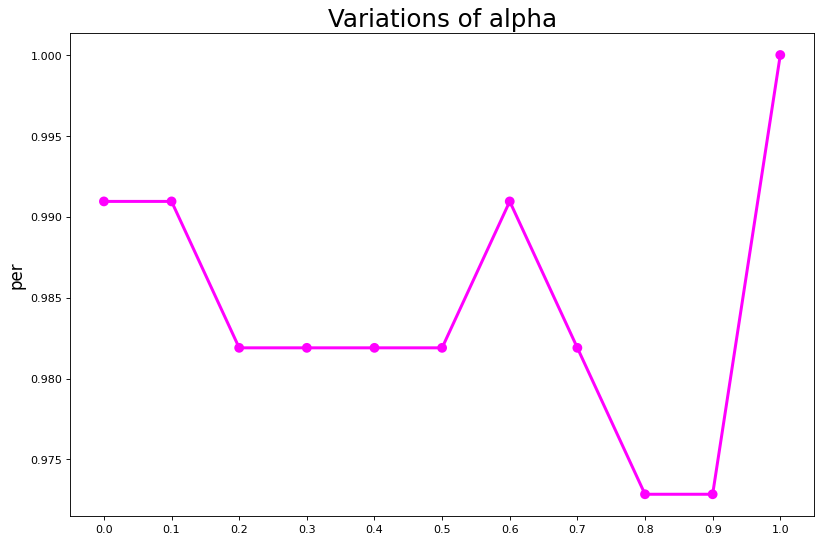

In [118]:
fig, ax = plt.subplots(figsize=(12,8), dpi= 80)    
sns.pointplot(x,y, jitter=0.25, size=8, ax=ax, color="magenta")
plt.title('Variations of alpha', fontsize=22)
plt.ylabel('per', fontsize=15)
plt.show()

### Data visualization

In [119]:
def creating_plt(binmask):
    driver = gdal.GetDriverByName("Gtiff")
    driver.Register()
    outds = driver.Create("binmask.tiff", binmask.shape[1], binmask.shape[0],  1, gdal.GDT_UInt16)
    geotransform = dataset.GetGeoTransform()
    outds.SetGeoTransform([geotransform[0], geotransform[1], geotransform[2], geotransform[3], geotransform[4], geotransform[5]])
    outds.SetProjection(dataset.GetProjection())
    
    outband = outds.GetRasterBand(1)
    outband.WriteArray(binmask)
    outband.FlushCache()
    outband.SetNoDataValue(np.nan)
    
    outds = None
    
    del binmask, outds
    
    mask_viz = gdal.Open("/Users/the_icecream/Desktop/проект/binmask.tiff", gdal.GA_ReadOnly)
    for x in range(1, mask_viz.RasterCount + 1):
        band = mask_viz.GetRasterBand(x)
        array_mask = band.ReadAsArray()
    return array_mask

In [120]:
creating_plt(true_mask[0])

array([[   36,    36,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    36,    36,    36,    36,    36],
       [   36,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    36,    36,    36,    36,    36,    36],
       [   36,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    36,    36,    36,    36,    36,    36],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,    36,    36,    36,    36,    36,    36,    36],
       [   36, 64537,     0,     0,     0,     0,     0,     0,     0,
            0,    36,    36,    36,    36,    36,    36,    36],
       [   36,    36,    36,     0,     0,     0,     0,     0,     0,
            0,    36,    36,    36,    36,    36,    36,    36],
       [   36,    36,    36,    36, 64537,     0,     0,     0,     0,
           36,    36,    36,    36,    36,    36,    36,    36],
       [   36,    36,    36,    36,    36,    36

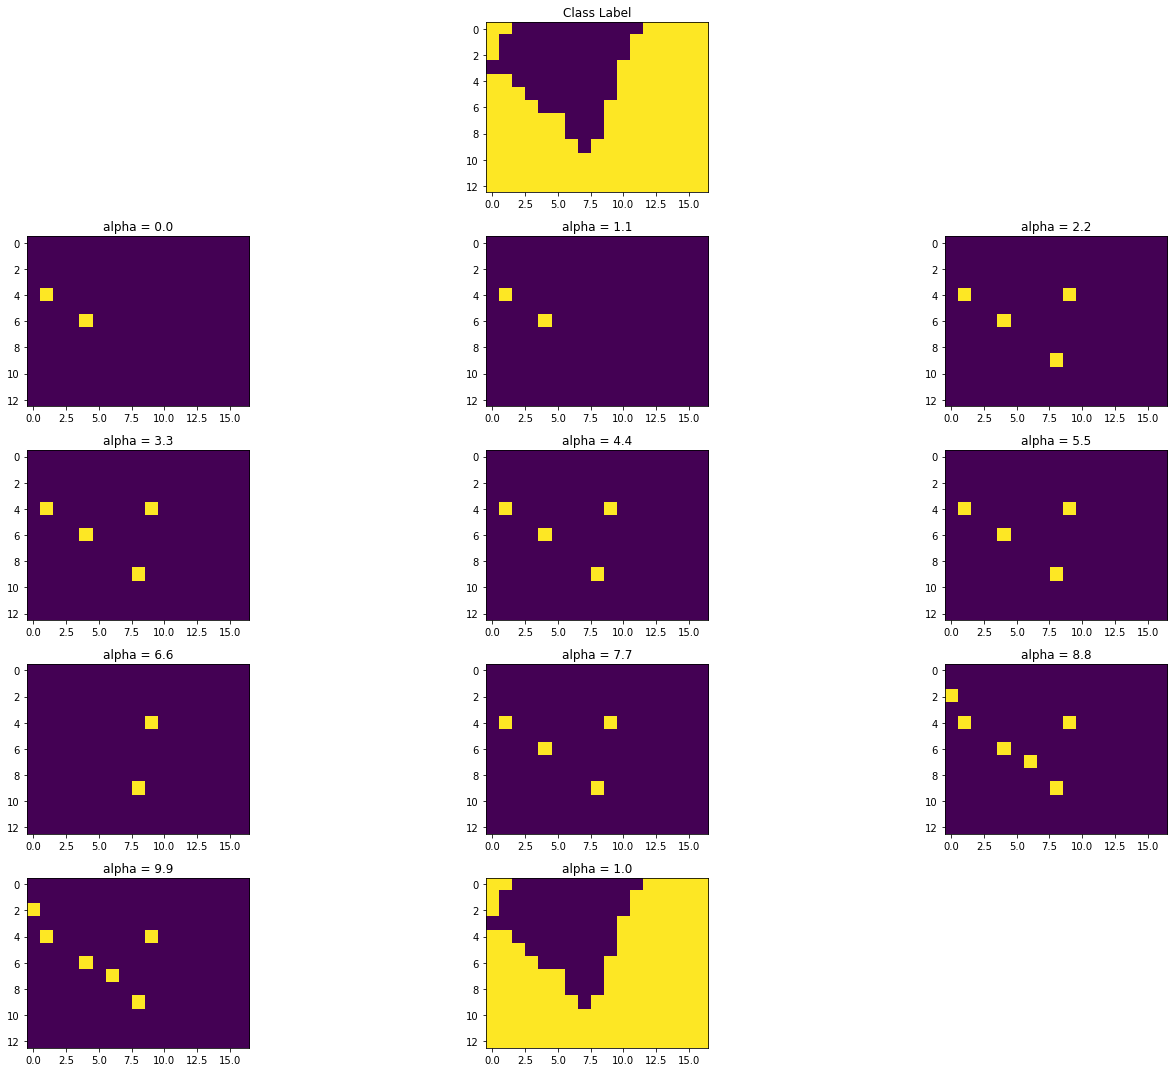

In [121]:
fig, axs = plt.subplots(5, 3, figsize=(20, 15))
axs[0,1].imshow(label)
axs[0,1].set_title("Class Label")
axs[0,0].remove()
axs[0,2].remove()
for i in range (1,5):
    for j in range(3):
        num = (i-1)*3+j
        if (num == 11):
            axs[i,j].remove()
        else:
            axs[i,j].imshow(true_mask[num])
            axs[i,j].set_title("alpha = "+ str(num/10+num%10))
fig.tight_layout()

In [122]:
x = np.zeros((array.shape[0], array.shape[1]), dtype='uint16')
for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if (true_mask[0][i][j]==true_mask[1][i][j]==true_mask[2][i][j]==true_mask[3][i][j]==true_mask[4][i][j]==true_mask[5][i][j]==true_mask[6][i][j]==true_mask[7][i][j]==true_mask[8][i][j]==true_mask[9][i][j]==true_mask[10][i][j]):
                x[i][j] = 1

In [ ]:
plt.imshow(x) #yellow - the same pixels in all masks

## Вопрос для консультации

In [ ]:
import time
start_time = time.time()
binmask = np.zeros((array.shape[0], array.shape[1]), dtype='uint16')
alpha = 0.4
names = [0]
r = SDT_train(array, bands, label, alpha, names, binmask)
print("--- %s minutes ---" % str((time.time() - start_time)/60.0))

In [ ]:
driver = gdal.GetDriverByName("Gtiff")
driver.Register()
outds = driver.Create("binmask.tiff", binmask.shape[1], binmask.shape[0],  1, gdal.GDT_UInt16)
geotransform = dataset.GetGeoTransform()
outds.SetGeoTransform([geotransform[0], geotransform[1], geotransform[2], geotransform[3], geotransform[4], geotransform[5]])
outds.SetProjection(dataset.GetProjection())

outband = outds.GetRasterBand(1)
outband.WriteArray(binmask)
outband.FlushCache()
outband.SetNoDataValue(np.nan)

outds = None

del binmask, outds

In [ ]:
mask_viz = gdal.Open("/Users/the_icecream/Desktop/проект/binmask.tiff", gdal.GA_ReadOnly)
for x in range(1, mask_viz.RasterCount + 1):
    band = mask_viz.GetRasterBand(x)
    array_mask = band.ReadAsArray()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 7))
axs[0].imshow(array_mask)
axs[0].set_title("Result of SDT, alpha = 1.0")
axs[1].imshow(label)
axs[1].set_title("Class Label")